In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
from os.path import join
import numpy as np

data_dir = '/content/drive/MyDrive/Colab/Data_dir'

def load_tfl_data(data_dir, crop_shape=(81, 81)):
    images = np.memmap(join(data_dir, 'data.bin'), mode='r', dtype=np.uint8).reshape([-1] + list(crop_shape) + [3])
    labels = np.memmap(join(data_dir, 'labels.bin'), mode='r', dtype=np.uint8)
    return {'images': images, 'labels': labels}

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D

def tfl_model():
    input_shape =(81,81,3)
    
    model = Sequential()
    def conv_bn_relu(filters,**conv_kw):
        model.add(Conv2D(filters,  use_bias=False, kernel_initializer='he_normal',**conv_kw))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.2))

    def dense_bn_relu(units):
        model.add(Dropout(0.15))
        model.add(Dense(units, use_bias=False,kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.1))

    
    def spatial_layer(count, filters): 
        for i in range(count):
            conv_bn_relu(filters,kernel_size=(3,3))
        conv_bn_relu(filters, kernel_size=(3,3),strides=(2,2))
    
    conv_bn_relu(32,kernel_size=(3,3),input_shape=input_shape)
    spatial_layer(1,32) 
    spatial_layer(2,64)
    spatial_layer(2,96) 
    
    
    model.add(Flatten())
    dense_bn_relu(10)
    model.add(Dense(2, activation='softmax'))
    return model
m = tfl_model()


In [46]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
data_dir = '/content/drive/MyDrive/Colab/Data_dir'
datasets = {
    'val':load_tfl_data(join(data_dir,'val')),
    'train': load_tfl_data(join(data_dir,'train')),
    }
# prepare our model
opt = Adam(learning_rate=0.01)
m.compile(optimizer=opt,loss =sparse_categorical_crossentropy,metrics=['accuracy'])

train,val = datasets['train'],datasets['val']
#train it, the model uses the 'train' dataset for learning. We evaluate the "goodness" of the model, by predicting the label of the images in the val dataset.
history=m.fit(train['images'],train['labels'],validation_data=(val['images'],val['labels']), epochs = 15, batch_size=100)

Epoch 1/15
205/205 [==============================] - 43s 202ms/step - loss: 0.0590 - accuracy: 0.9786 - val_loss: 0.3143 - val_accuracy: 0.9169
Epoch 2/15
205/205 [==============================] - 41s 200ms/step - loss: 0.0562 - accuracy: 0.9794 - val_loss: 0.3315 - val_accuracy: 0.9130
Epoch 3/15
205/205 [==============================] - 41s 200ms/step - loss: 0.0551 - accuracy: 0.9798 - val_loss: 0.4067 - val_accuracy: 0.9088
Epoch 4/15
205/205 [==============================] - 41s 200ms/step - loss: 0.0562 - accuracy: 0.9789 - val_loss: 0.2764 - val_accuracy: 0.9148
Epoch 5/15
205/205 [==============================] - 41s 200ms/step - loss: 0.0529 - accuracy: 0.9814 - val_loss: 0.3538 - val_accuracy: 0.9109
Epoch 6/15
205/205 [==============================] - 41s 200ms/step - loss: 0.0583 - accuracy: 0.9795 - val_loss: 0.2898 - val_accuracy: 0.9250
Epoch 7/15
205/205 [==============================] - 41s 200ms/step - loss: 0.0512 - accuracy: 0.9810 - val_loss: 0.2914 - val_ac

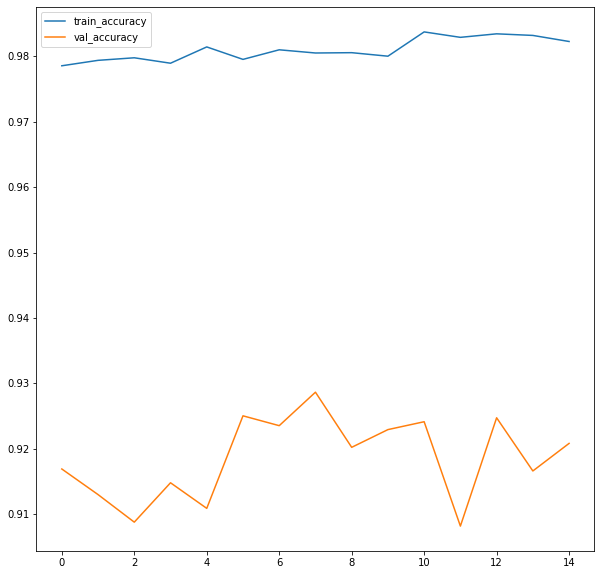

In [47]:
#compare train vs val acccuracy, 
# why is val_accuracy not as good as train accuracy? are we overfitting?
epochs = history.history
epochs['train_accuracy'] = epochs['accuracy']
plt.figure(figsize=(10,10))
for k in ['train_accuracy','val_accuracy']:
    plt.plot(range(len(epochs[k])), epochs[k],label=k)

plt.legend();

c:\users\chava neiman\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


accuracy: 0.9054786273329319


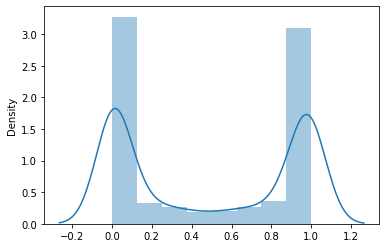

In [ ]:
import seaborn as sbn
predictions = m.predict(val['images'])
sbn.distplot(predictions[:,0]);

predicted_label = np.argmax(predictions, axis=-1)
print ('accuracy:', np.mean(predicted_label==val['labels']))

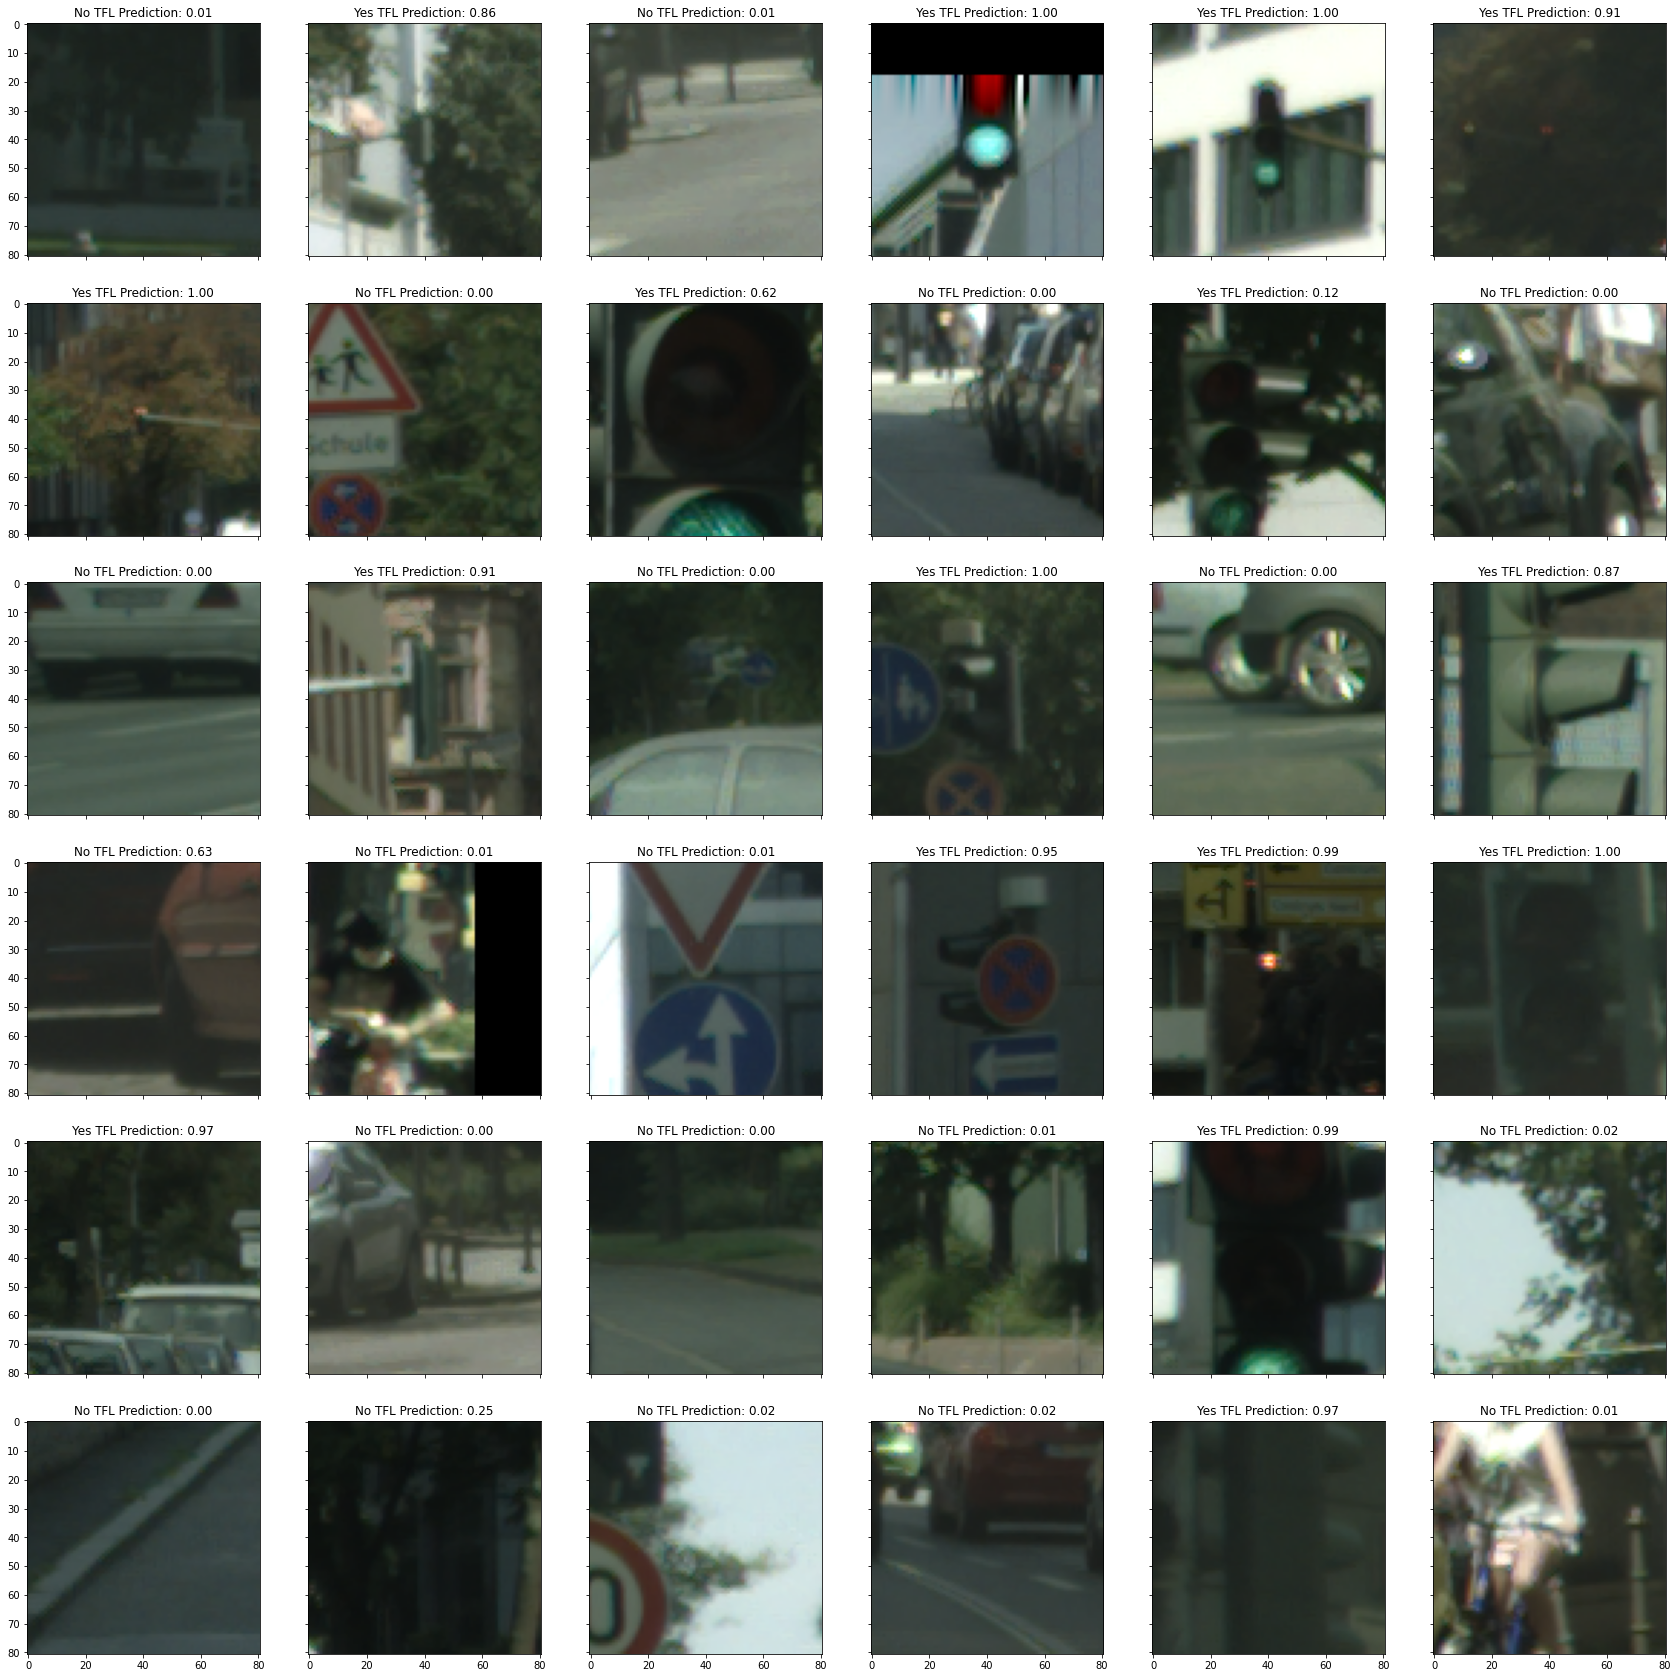

In [ ]:
viz_my_data(num=(6,6),predictions=predictions[:,1],**val);

In [ ]:
m.save("model.h5")

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model("model.h5")

accuracy: 0.9054786273329319


c:\users\chava neiman\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


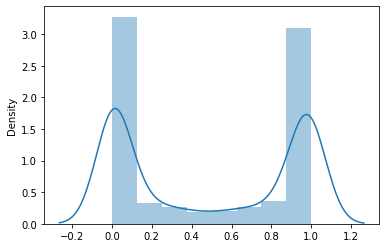

In [ ]:
# code copied from the training evaluation: 
l_predictions = loaded_model.predict(val['images'])
sbn.distplot(l_predictions[:,0]);

l_predicted_label = np.argmax(l_predictions, axis=-1)
print ('accuracy:', np.mean(l_predicted_label==val['labels']))